# Dataset Construction

This notebook builds the **AptaBench unified dataset** from multiple raw sources.

## 1. Imports & Config
* Load required Python libraries and custom functions
* Define paths to raw data and output dataset

In [16]:
# Add project root to sys.path so "src" is importable
import sys
from pathlib import Path

root = Path.cwd()
while not (root / "src").exists() and root.parent != root:
    root = root.parent

sys.path.insert(0, str(root))

In [17]:
# ========================================
# Basic packages
# ========================================
import re
import os
import numpy as np
import pandas as pd

# ========================================
# Custom preprocessing functions
# ========================================
from src.data.processing import (
    canonicalize_smiles_column,
    process_binding_constants,
    extract_target_name_from_description,
    resolve_smiles_by_name,
    clean_and_validate_sequences,
    resolve_smiles_by_name_or_pubchem_id,
    merge_inter_apt_exp,
    extract_clean_target_name,
    COLUMNS_LIST as columns_list,
)
from src.viz.plots import single_dataset_summary

RAW_DATA_DIR = "../data/raw"
INTERIM_DATA_DIR = "../data/interim"
OUTPUT_DATASET_PATH = "../dataset/AptaBench_dataset_v2.csv"
OUTPUT_DATASET_PARQUET = "../dataset/AptaBench_dataset_v2.parquet"

os.makedirs(INTERIM_DATA_DIR, exist_ok=True)

## 2. Load & Preprocess Individual Datasets
For each source:
- Load raw tables
- Normalize aptamer sequences
- Parse SMILES from name or ID
- Standardize SMILES
- Clean labels and outcomes

### 2.1 AptaDB
* Load: `aptadb-aptamer.csv`, `aptadb-molecule.csv`, `aptadb-interaction.csv`  
* Process → Output `df_aptadb`

In [19]:
inter = pd.read_csv(os.path.join(RAW_DATA_DIR, "AptaDB", 'aptadb-interaction.csv'), encoding='MacRoman')
apt = pd.read_csv(os.path.join(RAW_DATA_DIR, "AptaDB", 'aptadb-aptamer.csv'), encoding='MacRoman')
mol = pd.read_csv(os.path.join(RAW_DATA_DIR, "AptaDB", 'aptadb-molecule.csv'))

In [20]:
merged = inter.merge(apt, on='Apta_index', how='left', suffixes=('', '_apt'))
merged['TargetID_numeric'] = pd.to_numeric(merged['TargetID'], errors='coerce')
final = merged.merge(mol, left_on='TargetID_numeric', right_on='Pubchem ID', how='left')
df_1 = final[final['Target chemistry'] == 'Molecule']
df_1 = resolve_smiles_by_name_or_pubchem_id(
    df_1, identifier_column='TargetID', identifier_type='pubchem_id'
)
df_1 = df_1.dropna(subset=['canonical_smiles'])
df_1 = canonicalize_smiles_column(df_1, 'canonical_smiles', 'canonical_smiles')
df_1 = clean_and_validate_sequences(df_1, seq_col='Sequence')
df_1['Kd'] = np.nan
df_1 = process_binding_constants(df_1, column='Kd', unit='Kd')
df_1.loc[:, 'buffer'] = df_1['Binding Conditions/Buffer']
df_1.loc[:, 'origin'] = df_1['Reference(pubmed ID)']
df_1['source'] = 'AptaDB'
df_1 = df_1.dropna(subset=['canonical_smiles', 'sequence', 'type', 'label'])
df_aptadb = df_1[columns_list].drop_duplicates()

Querying PubChem by pubchem_id:   0%|          | 0/127 [00:00<?, ?it/s]

Querying PubChem by pubchem_id: 100%|██████████| 127/127 [08:41<00:00,  4.11s/it]


=== Dataset Summary ===
Total rows: 273
Unique sequences: 238
Unique molecules (SMILES): 91

Label distribution:
label
1    273


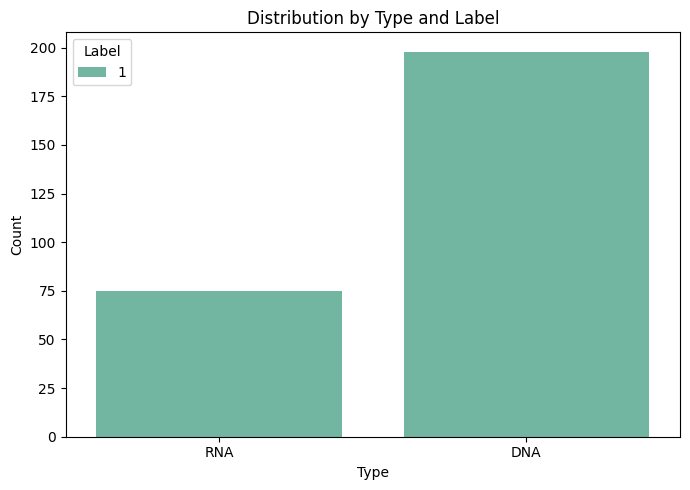

In [21]:
df_aptadb.to_csv(os.path.join(INTERIM_DATA_DIR, "aptadb_processed.csv"), index=False)
single_dataset_summary(df_aptadb)

### 2.2 AptamerBase
* Load: `aptamerbase_aptamers.csv`, `aptamerbase_experiments.csv`, `aptamerbase_interactions.csv`  
* Process → Output `df_aptamerbase`


In [22]:
intera = pd.read_csv(os.path.join(RAW_DATA_DIR, 'Aptamerbase','aptamerbase_interactions.csv'))
apta = pd.read_csv(os.path.join(RAW_DATA_DIR, 'Aptamerbase','aptamerbase_aptamers.csv'))
exp = pd.read_csv(os.path.join(RAW_DATA_DIR, 'Aptamerbase','aptamerbase_experiments.csv'))

In [23]:
df_2 = merge_inter_apt_exp(intera, apta, exp)
df_2 = extract_clean_target_name(df_2, column='participant_label')
df_2 = df_2[['dissociation_constant_value','sequence', 'pubmed', 'target_name']].dropna(subset=['sequence', 'target_name'])
df_2 = resolve_smiles_by_name(df_2, name_column='target_name')
df_2 = canonicalize_smiles_column(df_2, 'canonical_smiles', 'canonical_smiles')
df_2 = clean_and_validate_sequences(df_2, seq_col='sequence')
df_2 = process_binding_constants(df_2, column='dissociation_constant_value', unit='Kd')
df_2['buffer'] = np.nan
df_2['origin'] = df_2['pubmed'].apply(lambda x: f'https://pubmed.ncbi.nlm.nih.gov/{str(int(x))}/' if pd.notna(x) else np.nan)
df_2['source'] = 'Aptamer Base'
df_2 = df_2.dropna(subset=['canonical_smiles', 'sequence', 'type', 'label'])
df_aptamerbase = df_2[columns_list].drop_duplicates()

Querying PubChem: 100%|██████████| 360/360 [12:20<00:00,  2.06s/it]


=== Dataset Summary ===
Total rows: 334
Unique sequences: 312
Unique molecules (SMILES): 52

Label distribution:
label
1    323
0     11


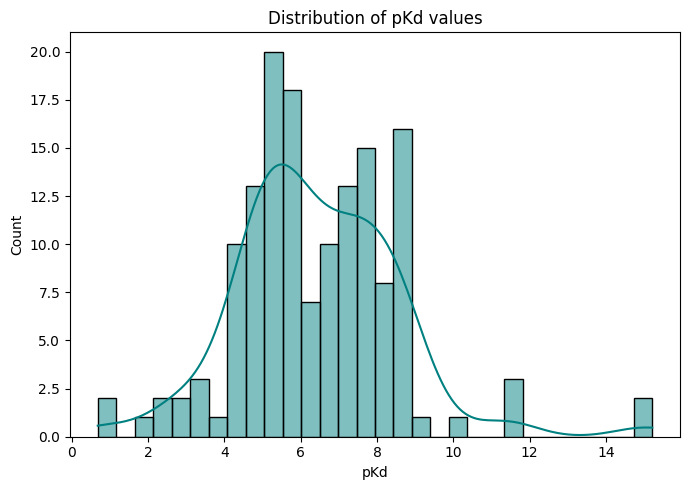

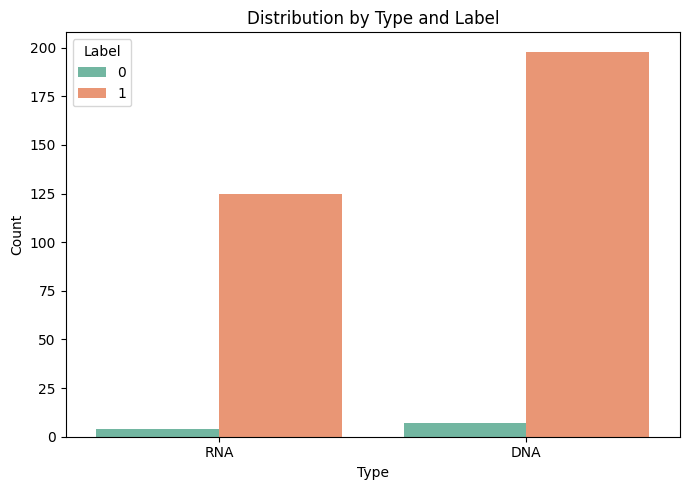

In [24]:
df_aptamerbase.to_csv(os.path.join(INTERIM_DATA_DIR, "aptamerbase_processed.csv"), index=False)
single_dataset_summary(df_aptamerbase)

### 2.3 AptaGen
* Load: `aptagen_RNA.csv` and `aptagen_DNA.csv` CSVs  
* Process → Output `df_aptagen`

In [25]:
df_3_rna = pd.read_csv(os.path.join(RAW_DATA_DIR, 'AptaGen', 'aptagen_RNA.csv')).drop_duplicates(subset='ID')
df_3_dna = pd.read_csv(os.path.join(RAW_DATA_DIR, 'AptaGen', 'aptagen_DNA.csv')).drop_duplicates(subset='ID')
df_3 = pd.concat([df_3_dna, df_3_rna], axis=0)

In [26]:
df_3_smiles = resolve_smiles_by_name(df_3, name_column='Target')
df_3 = df_3_smiles.dropna(subset=['Sequence', 'canonical_smiles'])
df_3 = canonicalize_smiles_column(df_3, 'canonical_smiles', 'canonical_smiles')
df_3 = clean_and_validate_sequences(df_3, seq_col='Sequence')
df_3 = process_binding_constants(df_3, column='Affinity (Kd)', unit='Kd')
df_3['buffer'] = df_3['Binding Conditions/Buffer']
df_3['origin'] = df_3['URL']
df_3['source'] = 'AptaGen'
df_3 = df_3.dropna(subset=['canonical_smiles', 'sequence', 'type', 'label'])
df_aptagen = df_3[columns_list].drop_duplicates()

Querying PubChem: 100%|██████████| 172/172 [06:25<00:00,  2.24s/it]


=== Dataset Summary ===
Total rows: 37
Unique sequences: 36
Unique molecules (SMILES): 28

Label distribution:
label
1    34
0     3


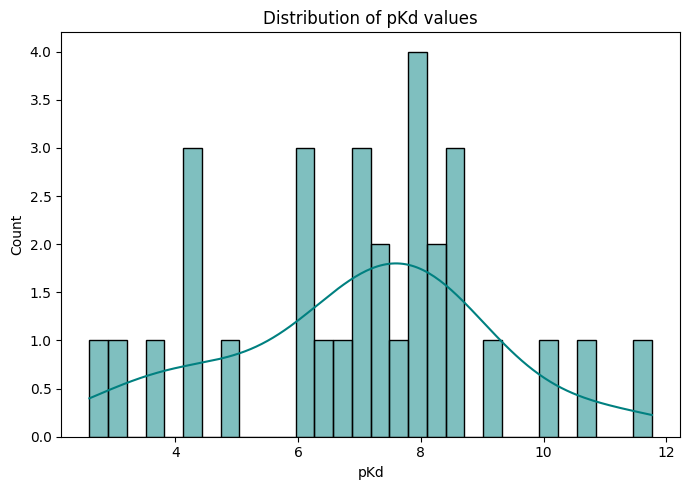

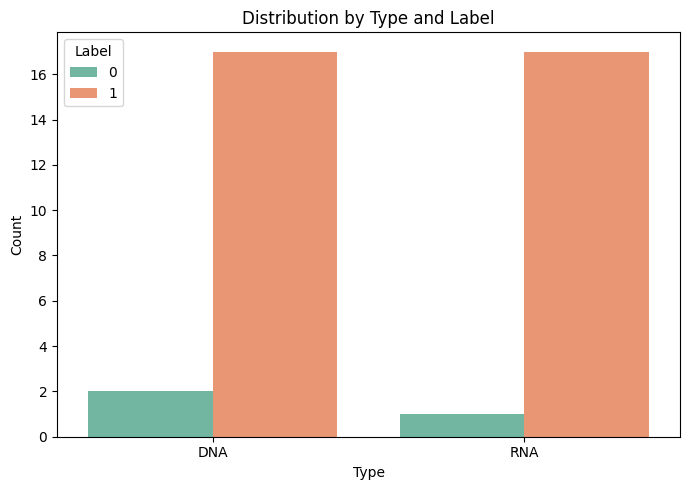

In [27]:
df_aptagen.to_csv(os.path.join(INTERIM_DATA_DIR, "aptagen_processed.csv"), index=False)
single_dataset_summary(df_aptagen)

### 2.4 RSAPred
* Load `rsapred.csv`  
* Process → Output `df_rsapred`

In [ ]:
df_4_1 = pd.read_csv(os.path.join(RAW_DATA_DIR, 'RSAPred', 'Aptamers_dataset_v1.csv'), sep = '\t')
df_4_2 = pd.read_csv(os.path.join(RAW_DATA_DIR, 'RSAPred', 'miRNA_dataset_v1.csv'), sep = '\t')
df_4_3 = pd.read_csv(os.path.join(RAW_DATA_DIR, 'RSAPred', 'Repeats_dataset_v1.csv'), sep = '\t')
df_4_4 = pd.read_csv(os.path.join(RAW_DATA_DIR, 'RSAPred', 'Ribosomal_dataset_v1.csv'), sep = '\t')
df_4_5 = pd.read_csv(os.path.join(RAW_DATA_DIR, 'RSAPred', 'Riboswitch_dataset_v1.csv'), sep = '\t')
df_4_6 = pd.read_csv(os.path.join(RAW_DATA_DIR, 'RSAPred', 'Viral_RNA_dataset_v1.csv'), sep = '\t')
df_4 = pd.concat([df_4_1, df_4_2, df_4_3, df_4_4, df_4_5, df_4_6])

,Entry_ID,SMILES,Target_RNA_sequence,Molecule_name,Molecule_ID,Target_RNA_name,Target_RNA_ID,pKd
0,39,C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3NC4=CC(=...,GGGAGAATTCCCGCGGCAGAAGCCCACCTGGCTTTGAACTCTATGT...,Cibacron blue,Target_lig_27,RNA_APTAMER_CB_42,Target_4,4.000000
1,40,C1=CC=C2C(=C1)C(=O)C3=C(C2=O)C(=C(C=C3NC4=CC(=...,GGGAGAAUUCCCGCGGCGUUGGCCCAGGAUAAUAGGACGAAAUCCG...,Reactive Blue 4,Target_lig_28,RNA_APTAMER_B4_25,Target_5,3.221849
2,91,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,GGGAAGGGAAGAAACUGCGGCUUCGGCCGGCUUCCC,ATP,Target_lig_65,RNA_Aptamer,Target_6,5.397940
3,92,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)O)O...,GGGAAGGGAAGAAACUGCGGCUUCGGCCGGCUUCCC,AMP,Target_lig_66,RNA_Aptamer,Target_6,8.301026
4,93,CC1=CC2=C(C=C1C)N(C3=NC(=O)NC(=O)C3=N2)CC(C(C(...,GGCGUGUAGGAUAUGCUUCGGCAGAAGGACACGCC,FAD,Target_lig_67,35 nucleotide RNA,Target_26,4.638272
...,...,...,...,...,...,...,...,...
276,2482,C1C(C(C(C(C1N)OC2C(C(C(C(O2)CO)O)O)N)OC3C(C(C(...,GGUGGGCGCAGCUUCGGCUGCGGACACC,Paromomycin,Target_lig_5,RRE4,Target_84,4.809668
277,2483,C1C(C(C(C(C1N)OC2C(C(C(C(O2)CO)O)O)N)OC3C(C(C(...,GGUGGGCGCAGCUUCGGCUGCGCAACCACC,Paromomycin,Target_lig_5,RRE11,Target_91,4.728158
278,2484,C1C(C(C(C(C1N)OC2C(C(C(C(O2)CO)O)N)O)O)OC3C(C(...,GGUGGGCGCAGCUUCGGCUGCGCCCACC,Kanamycin B,Target_lig_1287,RRE3,Target_83,4.903090
279,2485,C1C(C(C(C(C1N)OC2C(C(C(C(O2)CO)O)N)O)O)OC3C(C(...,GGUGGGCGCAGCUUCGGCUGCGGACACC,Kanamycin B,Target_lig_1287,RRE4,Target_84,5.200659


In [19]:
df_4 = canonicalize_smiles_column(df_4, 'SMILES', 'canonical_smiles')
df_4 = clean_and_validate_sequences(df_4, seq_col='Target_RNA_sequence')
df_4 = process_binding_constants(df_4, column='pKd', unit='pKd')
df_4['buffer'] = np.nan
df_4['origin'] = np.nan
df_4['source'] = 'RSAPred'
df_4 = df_4.dropna(subset=['canonical_smiles', 'sequence', 'type', 'label'])
df_rsapred = df_4[columns_list].drop_duplicates()

=== Dataset Summary ===
Total rows: 1412
Unique sequences: 295
Unique molecules (SMILES): 742

Label distribution:
label
1    1167
0     245


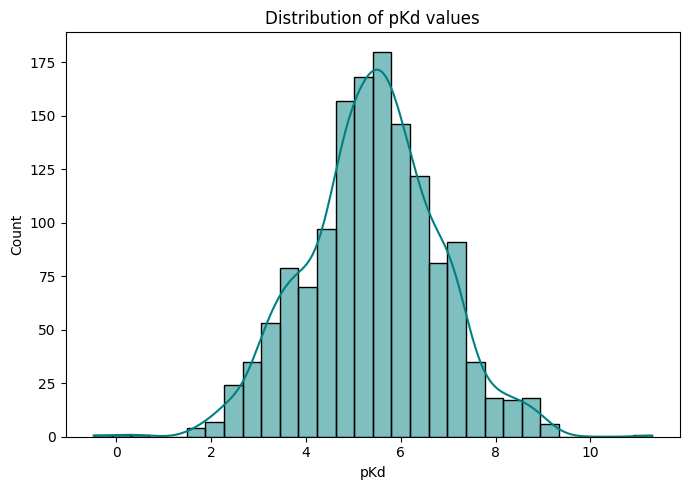

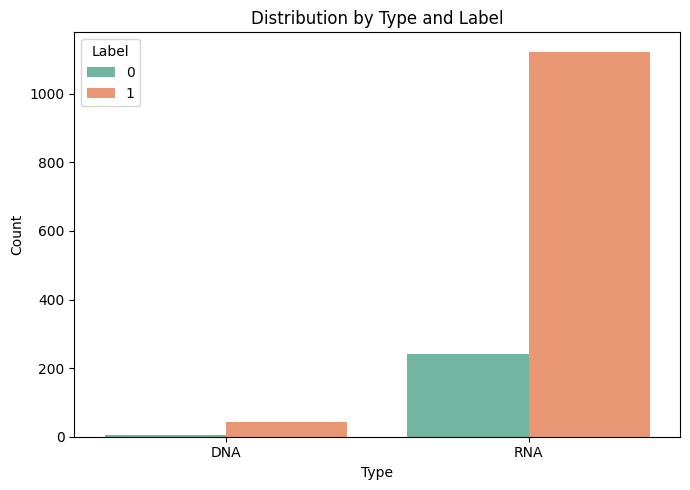

In [20]:
df_rsapred.to_csv(os.path.join(INTERIM_DATA_DIR, "rsapred_processed.csv"), index=False)
single_dataset_summary(df_rsapred)

### 2.5 Ribocentre
* Load `Ribocentre-aptamer.csv`  
* Process → Output `df_ribocentre`

In [31]:
df_5 = pd.read_csv(os.path.join(RAW_DATA_DIR, 'Ribocentre', 'Ribocentre-aptamer.csv'))

In [32]:
map_description_names = {
    'Theophylline, also known as 1,3-dimethylxanthine, is a drug that inhibits phosphodiesterase and blocks adenosine receptors. It is used to treat chronic obstructive pulmonary disease (COPD) and asthma. It is pharmacology is similar to other methylxanthine drugs (e.g., theobromine and caffeine)':'Theophylline',
    'ATP, or adenosine triphosphate, is a high - energy molecule that serves as the primary energy currency in cells, providing energy for various biological processes through the hydrolysis of its phosphate bonds.':'adenosine triphosphate',
    'Streptomycin (STR) is an antibiotic medication used to treat a number of bacterial infections, including tuberculosis, Mycobacterium avium complex, endocarditis, brucellosis, burkholderia infection, plague, tularemia, and rat bite fever. For active tuberculosis it is often given together with isoniazid, rifampicin, and pyrazinamide. It is administered by injection into a vein or muscle.':'Streptomycin',
    'Sulforhodamine B\xa0or\xa0Kiton Red 620 is a\xa0fluorescent\xa0dye\xa0with uses spanning from\xa0laser-induced fluorescence to the quantification of\xa0cellular\xa0proteins\xa0of\xa0cultured cells.':'Sulforhodamine B',
    "Second messenger adenosine 3',5'-cyclic monophosphate (cAMP; 1) is a small molecule that is formed intracellularly in response to the activation of certain cell surface receptors and serves to transmit extracellular signals into the cell, regulating various cellular processes such as metabolism, gene expression, and cell growth.":'cAMP',
    'Tetracycline antibiotics constitute a broad-spectrum class of compounds that share a common fundamental structure. They are either directly extracted from several species of Streptomyces bacteria or derived semi-synthetically from the compounds initially isolated from these bacteria.':'Tetracycline',
    "Beta amyloid peptide (βA4(1-40)) is a 40 amino acid long peptide fragment that is derived from the amyloid precursor protein and is a major component of the amyloid plaques found in the brains of patients with Alzheimer's disease.":'Beta amyloid peptide',
    'Hoechst stains are part of a family of blue fluorescent dyes used to stain DNA. These bis-benzimides were originally developed by Hoechst AG, which numbered all their compounds so that the dye Hoechst 33342 is the 33,342nd compound made by the company. There are three related Hoechst stains: Hoechst 33258, Hoechst 33342, and Hoechst 34580. The dyes Hoechst 33258 and Hoechst 33342 are the ones most commonly used and they have similar excitation-emission spectra.' :'Hoechst 33342',
    'GFP is a specific tri-amino acid sequence within the GFP structure that is responsible for its fluorescence properties, emitting green light when excited by an appropriate light source.':'GFP',
    'DFHBI ((Z)-4-(3,5-difluoro- 4-hydroxybenzylidene)-1,2-dimethyl-1H-imidazol-5(4H)-one) is a small molecule that resembles the chromophore of green fluorescent protein (GFP). Spinach and DFHBI are essentially nonfluorescent when unbound, whereas the Spinach-DFHBI complex is brightly fluorescent both in vitro and in living cells.':'DFHBI',
    'YO3 (Oxazole yellow 3) is a synthetic fluorescent small molecule whose spectral properties are very similar to Texas Red. YO3-biotin fluoresces with comparable intensities when bound in either the Mango or the Spinach construct, similarly to TO1-biotin. DFHBI-1T outcompetes YO3-biotin bound in Spinach, whereas YO3-biotin is unable to outcompete DFHBI-1T bound in Spinach.':'Oxazole yellow',
    'DIR is a cyanine dye that fluoresces blue when excited.':"1,1'-Dioctadecyl-3,3,3',3'-tetramethylindocarbocyanine perchlorate",
    'TMR (tetramethylrhodamine) is a rhodamine in which four hydrogens have been replaced by methyl groups. Forms such as tetramethylrhodamine dextran are often used as fluorescent tracer dyes in cell research.':'tetramethylrhodamine',
    'DMHBO+ ([4-[(2Z,4Z)-4-[(4-hydroxy-3,5-dimethoxyphenyl)methylidene]-2-(nitrosomethylidene)-5-oxoimidazolidin-1-yl]phenyl]-trimethylazanium) is a cationic chromophore that binds to the Chili aptamer with a Kd of 12 nM. The Chili-DMHBO+ complex is an ideal fluorescence donor for FRET to the rhodamine dye Atto 590, suitable for imaging RNA in cells. Ex/Em=456/592 nm.':'DMHBO+',
    'HBC ((4-((2-hydroxyethyl)(methyl)amino)-benzylidene)-cyanophenyl-acetonitrile) is a synthetic dye similar to GFP fluorophores, featuring a structurally rigid electron acceptor and a strong electron donor.':'(4-((2-hydroxyethyl)(methyl)amino)-benzylidene)-cyanophenyl-acetonitrile',
    'DFAME is a red fluorophore. Beetroot and Corn are dimeric fluorogenic RNA\xa0aptamers\xa0that can bind to DFAME to form Beetroot-DFAME (Kd=460 nM) and Corn-DFAME (Kd= 3600 nM). Beetroot-DFAME (Kd=460 nM) and Corn-DFAME can be used to form RNA assemblies in living cells. Creating RNA assemblies can be used for the study of RNA Nanostructures. DNA/RNA Nanostructures would be useful in cell and gene therapy (CGT) research.':'DFAME',
    'Hoechst stains are part of a family of blue fluorescent dyes used to stain DNA. These bis-benzimides were originally developed by Hoechst AG, which numbered all their compounds so that the dye Hoechst 33342 is the 33342nd compound made by the company. There are three related Hoechst stains: Hoechst 33258, Hoechst 33342, and Hoechst 34580. The dyes Hoechst 33258 and Hoechst 33342 are the ones most commonly used and they have similar excitation-emission spectra.':'Hoechst 33342',
    "DIR (1,1'-Dioctadecyl-3,3,3',3'-tetramethylindotricarbocyanine perchlorate) is a near-infrared fluorogenic dye widely employed as a target for light-up aptamers in biomedical imaging and molecular diagnostics. ": "1,1'-Dioctadecyl-3,3,3',3'-tetramethylindocarbocyanine perchlorate",
    'pAF (p-amino phenylalanine) is a non-proteinogenic amino acid derived from phenylalanine, featuring an amino group (-NH₂) substituted at the\xa0para-position of its phenyl ring.': '2-amino-3-(4-aminophenyl)propanoic acid',
    'DMHBI\u200b exemplifies a \u200bhigh-specificity fluorogen activatable by RNA aptamers, leveraging its \u200bconformational sensitivity\u200b and \u200borthogonal activation\u200b for advanced RNA imaging.':'DMHBI',
    'TMR-DN (Tetramethylrhodamine-Dinitroaniline)\u200b\u200b is a contact-quenched fluorogen pivotal for RNA imaging via the RhoBAST aptamer.  Its structural design enables exceptional brightness and photostability in super-resolution microscopy.':'Tetramethylrhodamine-Dinitroaniline',
    'Gemini-561\u200b denotes a \u200bcell-permeable, fluorogenic dimer of sulforhodamine B dyes\u200b engineered for high-performance RNA imaging via light-up aptamers.  Its avidity-driven binding and H-dimer quenching mechanism enable exceptional brightness and photostability.':'Gemini-561'
}

In [33]:
df_5 = extract_target_name_from_description(df_5[df_5['Type']=='Small molecules'], description_col='Description')
df_5['target_name'] = df_5.apply(
    lambda row: map_description_names[row['Description']] if row['Description'] in map_description_names else row['target_name'],
    axis=1
)
df_5_smiles = resolve_smiles_by_name(df_5, name_column='target_name')
df_5 = df_5_smiles.dropna(subset=['canonical_smiles'])
df_5 = canonicalize_smiles_column(df_5_smiles, 'canonical_smiles', 'canonical_smiles')
df_5 = clean_and_validate_sequences(df_5, seq_col='Sequence')
df_5['Kd'] = np.nan
df_5 = process_binding_constants(df_5, column='Kd', unit='Kd')
df_5['buffer'] = np.nan
df_5['origin'] = df_5['PubMed Link']
df_5['source'] = 'Ribocentre'
df_5 = df_5.dropna(subset=['canonical_smiles', 'sequence', 'type', 'label'])
df_ribocentre = df_5[columns_list].drop_duplicates()

Querying PubChem: 100%|██████████| 56/56 [02:06<00:00,  2.26s/it]


=== Dataset Summary ===
Total rows: 97
Unique sequences: 96
Unique molecules (SMILES): 40

Label distribution:
label
1    97


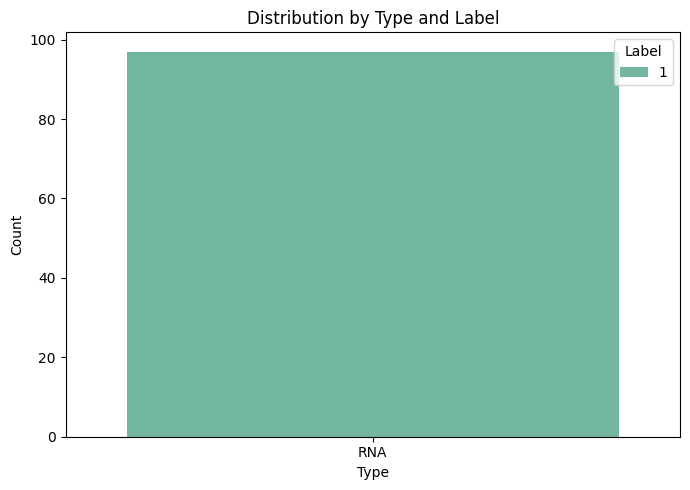

In [34]:
df_ribocentre.to_csv(os.path.join(INTERIM_DATA_DIR, "ribocentre_processed.csv"), index=False)
single_dataset_summary(df_ribocentre)

### 2.6 UTexas
* Load `UTexas.xlsx`  
* Process → Output `df_utexas`

In [11]:
df_6 = pd.read_excel(os.path.join(RAW_DATA_DIR, 'UTexas', 'UTexas.xlsx'))

In [12]:
df_6['clean_name'] = df_6['Target '].apply(
    lambda x: re.sub(r'\([^)]*\)', '', str(x)).split('/')[0].strip().strip(',') if pd.notna(x) else None
)
df_6_smiles = resolve_smiles_by_name(df_6, name_column='clean_name')
df_6 = df_6_smiles.dropna(subset=['canonical_smiles'])
df_6 = canonicalize_smiles_column(df_6_smiles, 'canonical_smiles', 'canonical_smiles')
df_6 = clean_and_validate_sequences(df_6, seq_col='Aptamer Sequence')
df_6['Kd (nM)'] = df_6['Kd (nM)'].apply(lambda x: str(x) + ' nM').astype(float, errors='ignore')
df_6 = process_binding_constants(df_6, column='Kd (nM)', unit='Kd')
df_6['buffer'] = df_6['Binding Buffer/Conditions']
df_6['origin'] = df_6['Link to PubMed Entry']
df_6['source'] = 'UTexas'
df_6 = df_6.dropna(subset=['canonical_smiles', 'sequence', 'type', 'label'])
df_utexas = df_6[columns_list].drop_duplicates()

Querying PubChem: 100%|██████████| 551/551 [22:07<00:00,  2.41s/it]


=== Dataset Summary ===
Total rows: 135
Unique sequences: 130
Unique molecules (SMILES): 47

Label distribution:
label
1    124
0     11


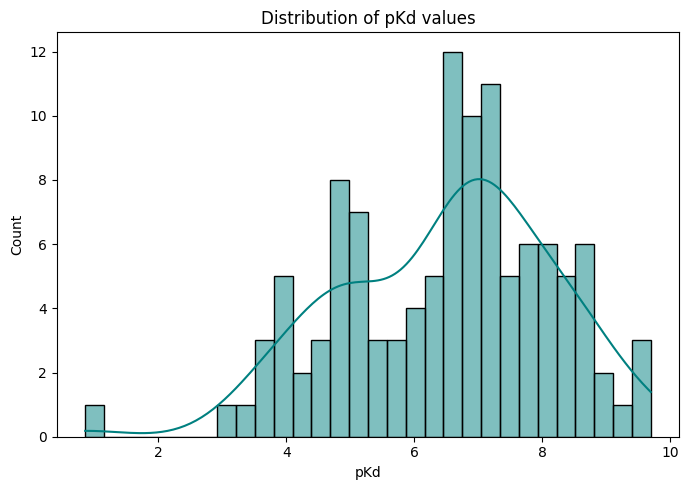

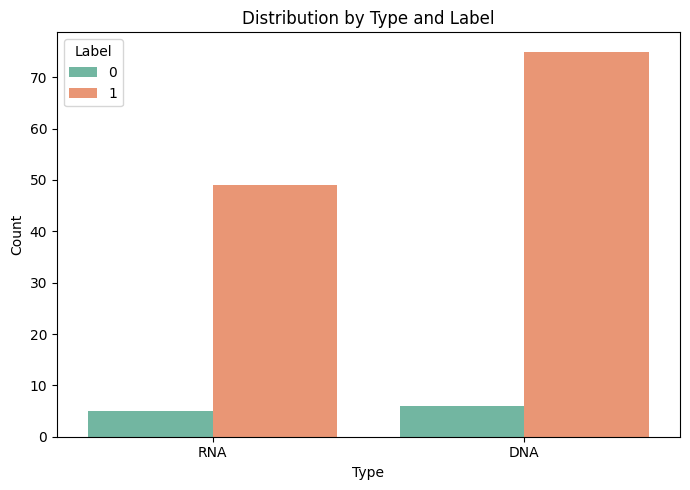

In [16]:
df_utexas.to_csv(os.path.join(INTERIM_DATA_DIR, "utexas_processed.csv"), index=False)
single_dataset_summary(df_utexas)

### 2.7 Manual Curation
* Load `manual_aptamer_database.xlsx`  
* Process → Output `df_manual`

In [14]:
df_7 = pd.read_excel(os.path.join(RAW_DATA_DIR, 'Manual', 'manual_aptamer_database.xlsx'), header=1)

In [15]:
df_7 = canonicalize_smiles_column(df_7, 'molecular_target_smiles', 'canonical_smiles')
df_7 = clean_and_validate_sequences(df_7, seq_col='aptamer_sequence')
df_7['Kd'] = df_7['kd_value'].astype(str) + ' ' + df_7['kd_units'].astype(str)
df_7 = process_binding_constants(df_7, column='Kd', unit='Kd')
df_7['buffer'] = df_7['buffer_conditions'] + ', pH = '+ df_7['ph'].astype(str)
df_7['origin'] = df_7['DOI (add it as link)']
df_7['source'] = 'Manual'
df_7 = df_7.dropna(subset=['canonical_smiles', 'sequence', 'type', 'label'])
df_manual = df_7[columns_list].drop_duplicates()

=== Dataset Summary ===
Total rows: 680
Unique sequences: 518
Unique molecules (SMILES): 160

Label distribution:
label
1    600
0     80


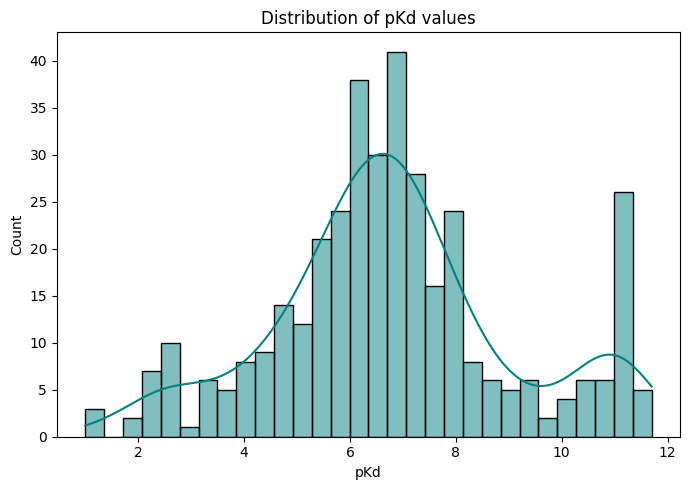

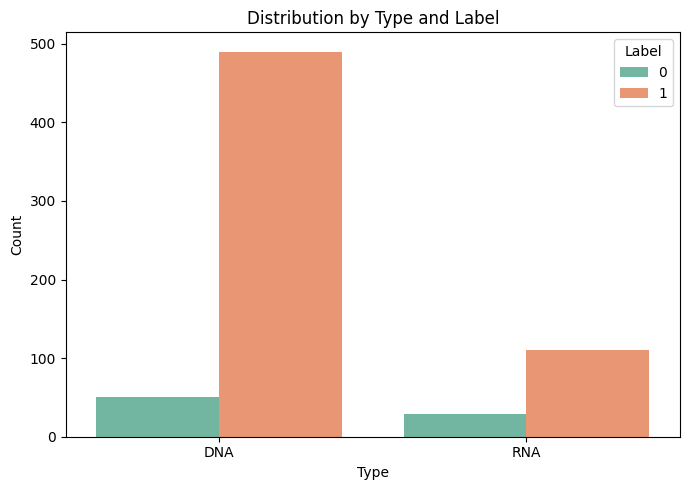

In [17]:
df_manual.to_csv(os.path.join(INTERIM_DATA_DIR, "manual_processed.csv"), index=False)
single_dataset_summary(df_manual)

### Specificity data (negatives)

In [5]:
df_8 = pd.read_csv(os.path.join(RAW_DATA_DIR, 'Manual', 'specificity_data.csv'))
df_8

,Aptamer,Small_Molecule,Interaction_Value,KD (nM),ΔHbind (kcal/mol),ΔSbind (cal/mol/K),TΔSbind (kcal/mol),Binding Sites,Reference,SMILES,Sequence
0,NC1,AB-FUBINACA,0.01279,NaN,NaN,NaN,NaN,NaN,NaN,CC(C)[C@@H](C(=O)N)NC(=O)C1=NN(C2=CC=CC=C21)CC...,CTTACGACCTGTTCTGAGGGTCAACCTTTGGTGTAGTGGTCGTAAG
1,NC1,Alprazolam,0.00618,NaN,NaN,NaN,NaN,NaN,NaN,Cc1nnc2CN=C(c3ccccc3)c4cc(Cl)ccc4n12,CTTACGACCTGTTCTGAGGGTCAACCTTTGGTGTAGTGGTCGTAAG
2,NC1,Benzoylecgonine,0.19945,NaN,NaN,NaN,NaN,NaN,NaN,CN1C2CCC1[C@H]([C@H](C2)OC(=O)c3ccccc3)C(O)=O,CTTACGACCTGTTCTGAGGGTCAACCTTTGGTGTAGTGGTCGTAAG
3,NC1,Cocaine,1.00000,216.0,-28.0,-63.7,-18.9,1.06,1,COC(=O)[C@H]1[C@H](CC2CCC1N2C)OC(=O)c3ccccc3,CTTACGACCTGTTCTGAGGGTCAACCTTTGGTGTAGTGGTCGTAAG
4,NC1,Diphenhydramine,0.00920,NaN,NaN,NaN,NaN,NaN,NaN,CN(C)CCOC(c1ccccc1)c2ccccc2,CTTACGACCTGTTCTGAGGGTCAACCTTTGGTGTAGTGGTCGTAAG
...,...,...,...,...,...,...,...,...,...,...,...
3616,FXb,Flunixin,NaN,9500.0,-17.4,-36.0,-10.7,0.92,4,CC1=C(C=CC=C1NC2=C(C=CC=N2)C(=O)O)C(F)(F)F,GGGACGACAGTAGGGGTGTAGGGGTGGTTGGACTCACTGTCGTCCC
3617,FXc,Flunixin,NaN,4700.0,-9.4,-7.4,-2.2,1.01,4,CC1=C(C=CC=C1NC2=C(C=CC=N2)C(=O)O)C(F)(F)F,GGGACGACGGCCCCAGTGAGGAGGTAGAGGTGTTCGCTGTCGTCCC
3618,FXd,Flunixin,NaN,27400.0,-8.5,-7.7,-2.3,0.79,4,CC1=C(C=CC=C1NC2=C(C=CC=N2)C(=O)O)C(F)(F)F,GGGACGACGGTGTGGGGGTAGGGGGTGTGGGAAGCGGCGTCGTCCC
3619,FXe,Flunixin,NaN,6700.0,-14.2,-24.0,-7.1,0.78,4,CC1=C(C=CC=C1NC2=C(C=CC=N2)C(=O)O)C(F)(F)F,GGGACGACTGGGGGTTGGTAAGGTTAGGTTCTTGTGAGGTCGTCCC


In [8]:
df_8 = canonicalize_smiles_column(df_8, 'SMILES', 'canonical_smiles')
df_8 = clean_and_validate_sequences(df_8, seq_col='Sequence')
df_8['Kd'] = df_8['KD (nM)'].astype(str) + ' ' + 'nM'
df_8 = process_binding_constants(df_8, column='Kd', unit='Kd')
df_8['label'] = (df_8['Interaction_Value'] >= 0.2).astype(int)
df_8['buffer'] = '10 mM Tris-HCl, pH 7.4'
df_8['origin'] = 'https://doi.org/10.1093/nar/gkaf219'
df_8['source'] = 'Specificity'
df_8 = df_8.dropna(subset=['canonical_smiles', 'sequence', 'type', 'label'])
df_specificity = df_8[columns_list].drop_duplicates()

=== Dataset Summary ===
Total rows: 3588
Unique sequences: 234
Unique molecules (SMILES): 75

Label distribution:
label
0    2725
1     863


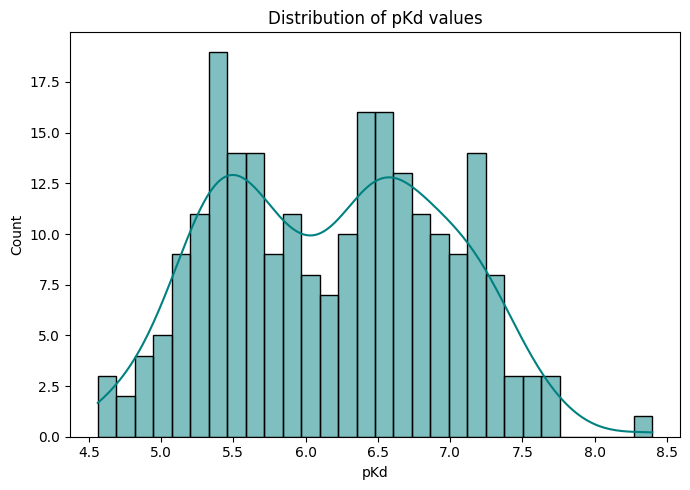

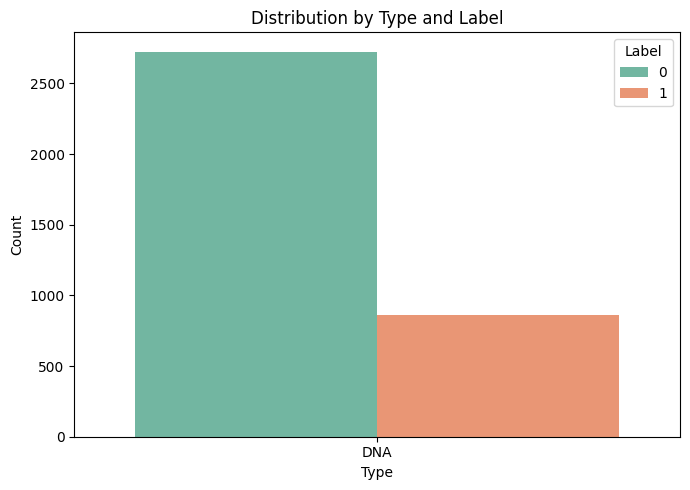

In [9]:
df_specificity.to_csv(os.path.join(INTERIM_DATA_DIR, "specificity_processed.csv"), index=False)
single_dataset_summary(df_specificity)

## 3. Merge into Unified Dataset
- Concatenate all processed DataFrames
- Deduplicate by (sequence, SMILES, target)
- Save preprocessed source datasets → `data/interim/{database_name}_processed.csv`
- Save unified DataFrame → `dataset/AptaBench_dataset.csv`

In [21]:
df_rsapred = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "rsapred_processed.csv"))
df_aptamerbase = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "aptamerbase_processed.csv"))
df_aptagen = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "aptagen_processed.csv"))
df_utexas = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "utexas_processed.csv"))
df_ribocentre = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "ribocentre_processed.csv"))
df_aptadb = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "aptadb_processed.csv"))
df_manual = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "manual_processed.csv"))
df_specificity = pd.read_csv(os.path.join(INTERIM_DATA_DIR, "specificity_processed.csv"))

In [24]:
# All datasets list
dfs = {'RSAPred': df_rsapred, 
       'Aptamerbase':df_aptamerbase, 
       'AptaGen': df_aptagen, 
       'UTexas':df_utexas, 
       'Ribocentre':df_ribocentre, 
       'AptaDB':df_aptadb, 
       'Manual':df_manual,
       'Specificity':df_specificity}


# Merge
combined_df = pd.concat(dfs, ignore_index=True).drop_duplicates(subset=['sequence', 'canonical_smiles', 'pKd_value'])
for col in ["origin", "buffer", "source"]:
    if col in combined_df.columns:
        combined_df[col] = combined_df[col].astype(str)
combined_df = combined_df[combined_df['sequence'].apply(len)<=200]
print(f"Combined dataset: {combined_df.shape[0]} rows, {combined_df.shape[1]} columns")

Combined dataset: 6413 rows, 8 columns


In [25]:
os.makedirs(os.path.dirname(OUTPUT_DATASET_PATH), exist_ok=True)
combined_df.to_csv(OUTPUT_DATASET_PATH, index=False)
combined_df.to_parquet(OUTPUT_DATASET_PARQUET, index=False, engine="fastparquet")